# Prompt

Using a dataset of your own, explore the data utilizing multiple cross-validation techniques. Choose the most appropriate cross-validation technique for your data.

In your initial post, describe your data, state which cross-validation technique you used, and explain your rationale for deciding on which cross-validation technique was the most appropriate for your specific dataset.

# Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.utils import shuffle
from sklearn.feature_selection import SequentialFeatureSelector
import plotly.express as px

np.random.seed(1234)

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

In [3]:
df = pd.read_csv("./data/diabetes.csv")
# display(df.head())
# display(df.info())
df.dropna(inplace=True)
# display(df.head())
# display(df.info())

In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
df = df.drop(columns="Outcome")

In [6]:
# sns.pairplot(df)

In [7]:
features_with_zero_as_null = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
]
for feature in features_with_zero_as_null:
    df = df.query(feature + ">0")

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000


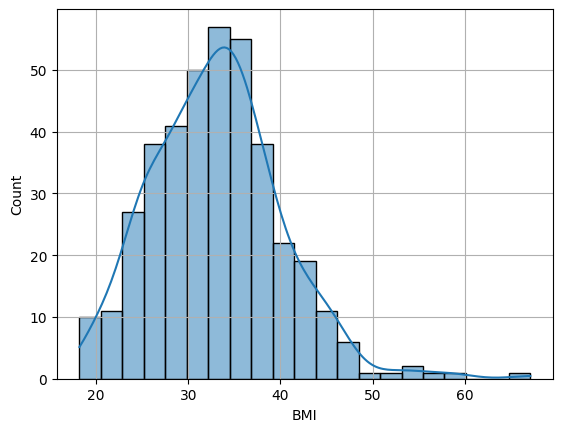

In [9]:
def sns_histplot(data: pd.DataFrame, x: str = ""):
    sns.histplot(
        data=df,
        x=x,
        kde=True,
        palette=sns.color_palette("bright")[:3],
    )


sns_histplot(df, x="BMI")

In [10]:
df = df.query("BMI < 50")

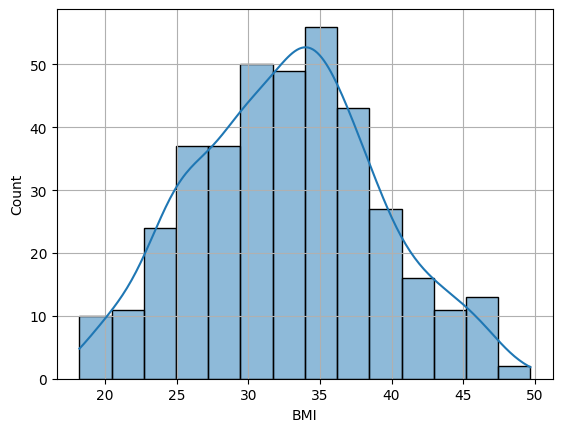

In [11]:
sns_histplot(df, x="BMI")

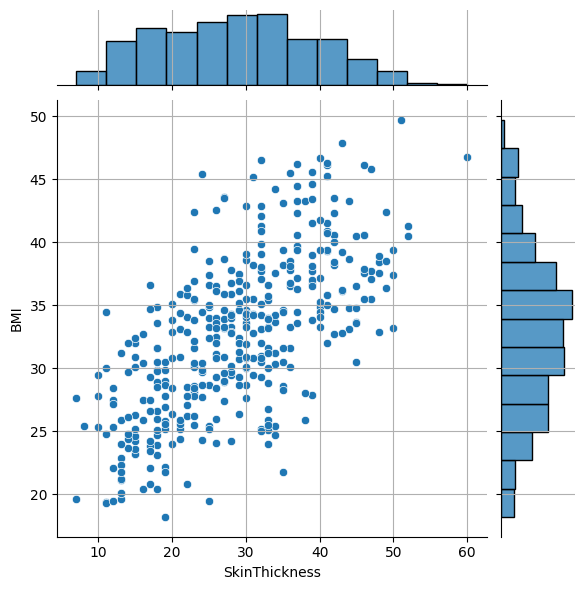

In [19]:
# sns.jointplot(df, x="SkinThickness", y="BMI")

In [12]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,3.341969,122.339378,70.507772,28.886010,155.209845,32.708549,0.517443,30.963731
std,3.216379,30.768281,12.117228,10.300799,116.364095,6.358559,0.333518,10.247013
min,0.000000,56.000000,24.000000,7.000000,15.000000,18.200000,0.085000,21.000000
25%,1.000000,99.000000,62.000000,21.000000,76.250000,28.325000,0.269000,23.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.100000,0.446500,27.000000
75%,5.000000,143.000000,78.000000,36.000000,190.000000,36.875000,0.681000,36.000000
max,17.000000,198.000000,110.000000,60.000000,846.000000,49.700000,2.329000,81.000000


In [13]:
# sns.pairplot(df)

# Problem Statement and Model Setup

## Problem Statement

The data set contains the target feature - median_house_value - and we wish to develop a model from the other features to predict this feature.  

Take 2: using the diabetes data set, make BMI the target feature. I realize the objective of this data set is predicting diabetes, not BMI, but I was interested in a numeric, not categorical feature, so I somewhat arbitrarily decided to check if I could predict BMI given the other features.

## Model Setup

We will establish a pipeline of:
- Polynomial features
- Standardization
- Ridge Regression

and declare the hyperparameter of interest to be the alpha parameter for ridge.

We also saw that polynomial performance (more so on higher-order models) suffered unless the data was scaled prior to doing the polynomial feature transformation, so we will scale the data up front once.

### Defining Target and Regression Features

In [14]:
target_feature = "BMI"
numeric_features = df.columns[df.dtypes != "object"].to_list()
numeric_features.remove(target_feature)

display([target_feature, numeric_features])

['BMI',
 ['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'DiabetesPedigreeFunction',
  'Age']]

### Standardize

In [15]:
df_zscores = df.copy(deep=True)
df_zscores[numeric_features] = StandardScaler().fit_transform(df[numeric_features])
df_zscores.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
3,-0.729083,-1.084970,-0.372496,-0.572155,-0.526703,28.1,-1.052109,-0.973617
4,-1.040396,0.477103,-2.520986,0.594316,0.110058,43.1,5.315613,0.198976
6,-0.106459,-1.442945,-1.694644,0.302698,-0.578332,31.0,-0.808929,-0.485036
8,-0.417771,2.429694,-0.041959,1.566374,3.336884,30.5,-1.079129,2.153298
13,-0.729083,2.169349,-0.868302,-0.572155,5.944159,30.1,-0.358595,2.739594


In [16]:
df_zscores.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,3.860000e+02,3.860000e+02,3.860000e+02,3.860000e+02,3.860000e+02,386.000000,3.860000e+02,3.860000e+02
mean,4.601961e-17,1.484132e-16,4.256814e-16,2.761176e-17,2.070882e-17,32.708549,1.104471e-16,1.840784e-17
std,1.001298e+00,1.001298e+00,1.001298e+00,1.001298e+00,1.001298e+00,6.358559,1.001298e+00,1.001298e+00
min,-1.040396e+00,-2.158895e+00,-3.843134e+00,-2.127448e+00,-1.206487e+00,18.200000,-1.298292e+00,-9.736166e-01
25%,-7.290835e-01,-7.595377e-01,-7.030332e-01,-7.665663e-01,-6.794392e-01,28.325000,-7.458821e-01,-7.781845e-01
50%,-4.177713e-01,-1.086740e-01,-4.195935e-02,1.108046e-02,-2.556493e-01,33.100000,-2.129870e-01,-3.873202e-01
75%,5.161653e-01,6.723624e-01,6.191145e-01,6.915214e-01,2.993647e-01,36.875000,4.910351e-01,4.921245e-01
max,4.251912e+00,2.462238e+00,3.263410e+00,3.024462e+00,5.944159e+00,49.700000,5.438704e+00,4.889348e+00


### Split into Training and Development

In [17]:
all_inds = shuffle(range(len(df_zscores)), random_state=42)
(train_inds, dev_inds) = np.split(all_inds, [int(0.7 * len(df_zscores))])
display([train_inds[:10], dev_inds[:10]])

# Perform the split using same method as will use in sklearn / SFS
X_train = df_zscores[numeric_features].iloc[train_inds]
y_train = df_zscores.iloc[train_inds][target_feature]
X_dev = df_zscores[numeric_features].iloc[dev_inds]
y_dev = df_zscores.iloc[dev_inds][target_feature]

[array([336, 307,  90, 265, 150, 297,  78, 101, 312,  33]),
 array([256, 356, 100, 226, 329, 213, 171,  98, 215,  61])]

### Build Pipeline

In [21]:
degree = 2
estimator = Pipeline(
    [
        ("transform", PolynomialFeatures(degree=degree, include_bias=False)),
        ("scale", StandardScaler()),
        ("regression", Ridge()),
    ]
)

### Specify Hyperparameter Search

In [32]:
alpha_list = 10 ** np.linspace(-7, 7, 301)

# Cross Validation with Holdout

In [33]:
param_grid = {"regression__alpha": alpha_list}
model_finder = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=[[train_inds, dev_inds]],
).fit(df_zscores[numeric_features], df_zscores[target_feature])

In [34]:
best_estimator = model_finder.best_estimator_
best_estimator

Pipeline(steps=[('transform', PolynomialFeatures(include_bias=False)),
                ('scale', StandardScaler()),
                ('regression', Ridge(alpha=22.559700688435772))])

In [36]:
mse_per_alpha = model_finder.cv_results_["mean_test_score"]
# mse_per_alpha

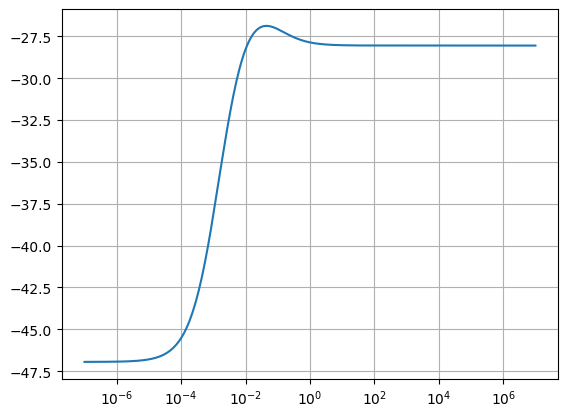

In [38]:
plt.plot(1.0 / alpha_list, mse_per_alpha, label="Dev")
plt.xscale("log")
# plt.legend()

# Cross Validation with K-Fold

# Cross Validation with Leave One Out

# Comparisons

# Conclusions